In [1]:
from matplotlib.colors import LinearSegmentedColormap

from utils_figs import *

plt.rcParams["figure.dpi"] = 150
sns.set_style("whitegrid")

bw2 = ["#c0c0c0", "#606060"]
cmap = LinearSegmentedColormap.from_list("bw", bw2[::-1])

# Main

## Impact on colleges

### Percent minority enrolled

#### Figure 2

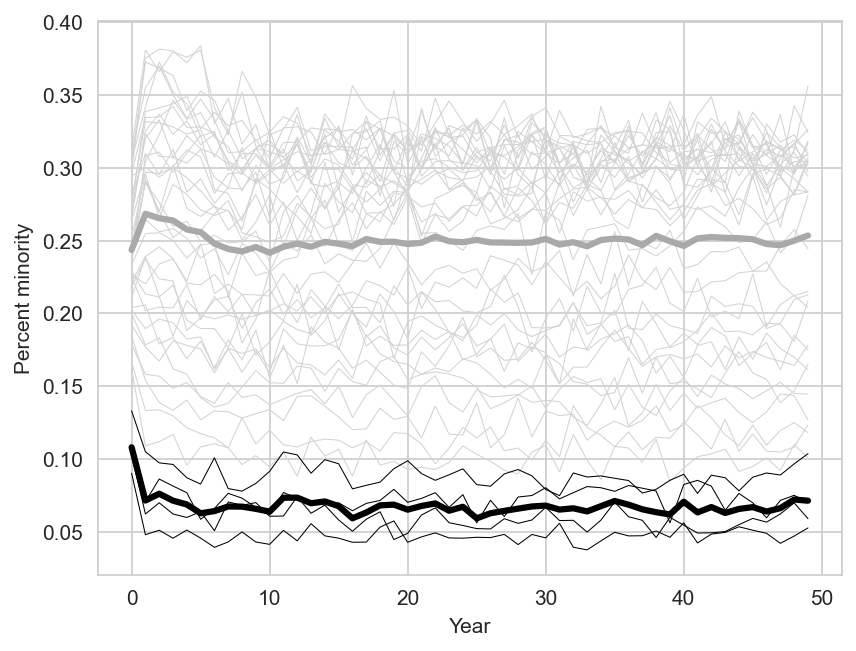

In [2]:
fig_c1 = changes_bh_enrollment(n_years=50)
fig_c1.savefig("figures/figC1.png", bbox_inches="tight")

#### Figure 3

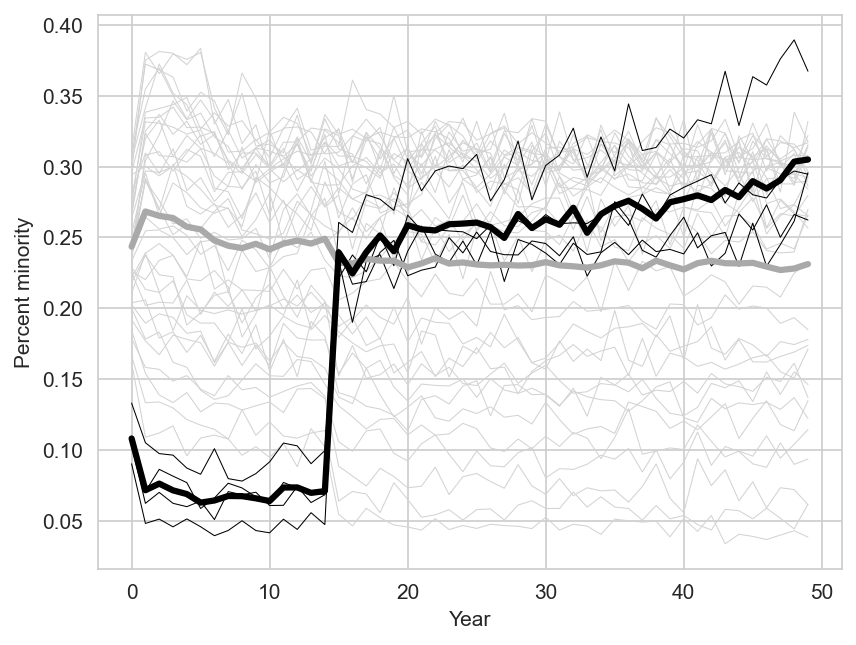

In [3]:
fig_c2 = changes_bh_enrollment(n_years=50, wgt_aa_race=260)
fig_c2.savefig("figures/figC2.png", bbox_inches="tight")

#### Figure 4

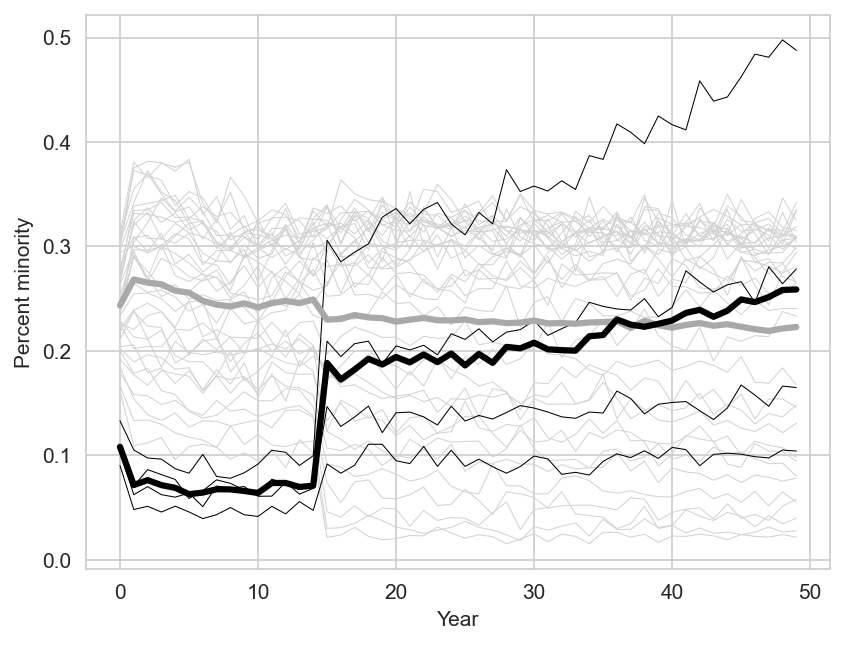

In [4]:
fig_c4 = changes_bh_enrollment(n_years=50, wgt_aa_ses=150, wgt_recruit=100)
fig_c4.savefig("figures/figC4.png", bbox_inches="tight")

## Quality

### Figure 5

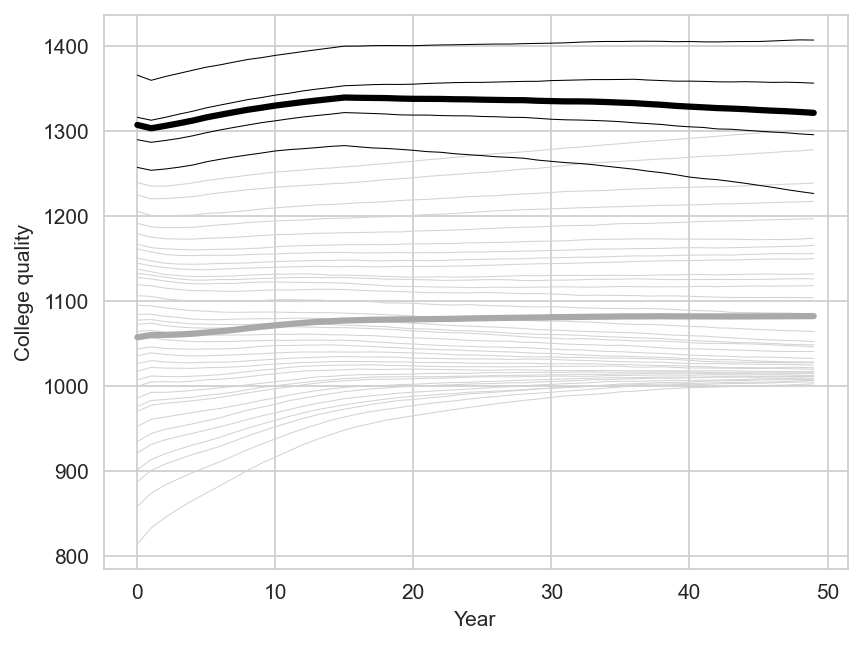

In [5]:
fig_c5 = changes_coll_qual(n_years=50, wgt_aa_ses=150, wgt_recruit=100)
fig_c5.savefig("figures/figC5.png", bbox_inches="tight")

## Impact on racial and SES groups

### Figure 6

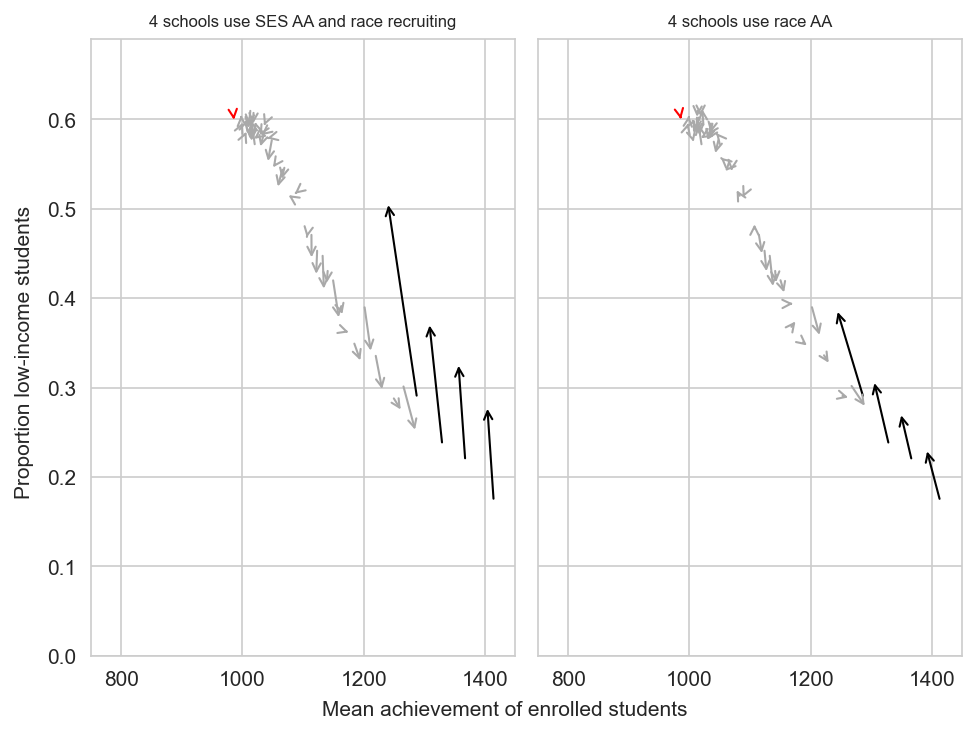

In [6]:
scenario_d1 = {
    "4 schools use SES AA and race recruiting": run_repeat_agg(coll_shift_aux, wgt_aa_ses=150, wgt_recruit=100),
    "4 schools use race AA": run_repeat_agg(coll_shift_aux, wgt_aa_race=260)
}

fig_d1 = plot_d123(scenario_d1, "res")
fig_d1.supxlabel('Mean achievement of enrolled students', y=-.01, fontsize="medium")
fig_d1.supylabel('Proportion low-income students', x=-.01, fontsize="medium")
fig_d1.savefig("figures/figD1.png", bbox_inches="tight")

### Figure 7

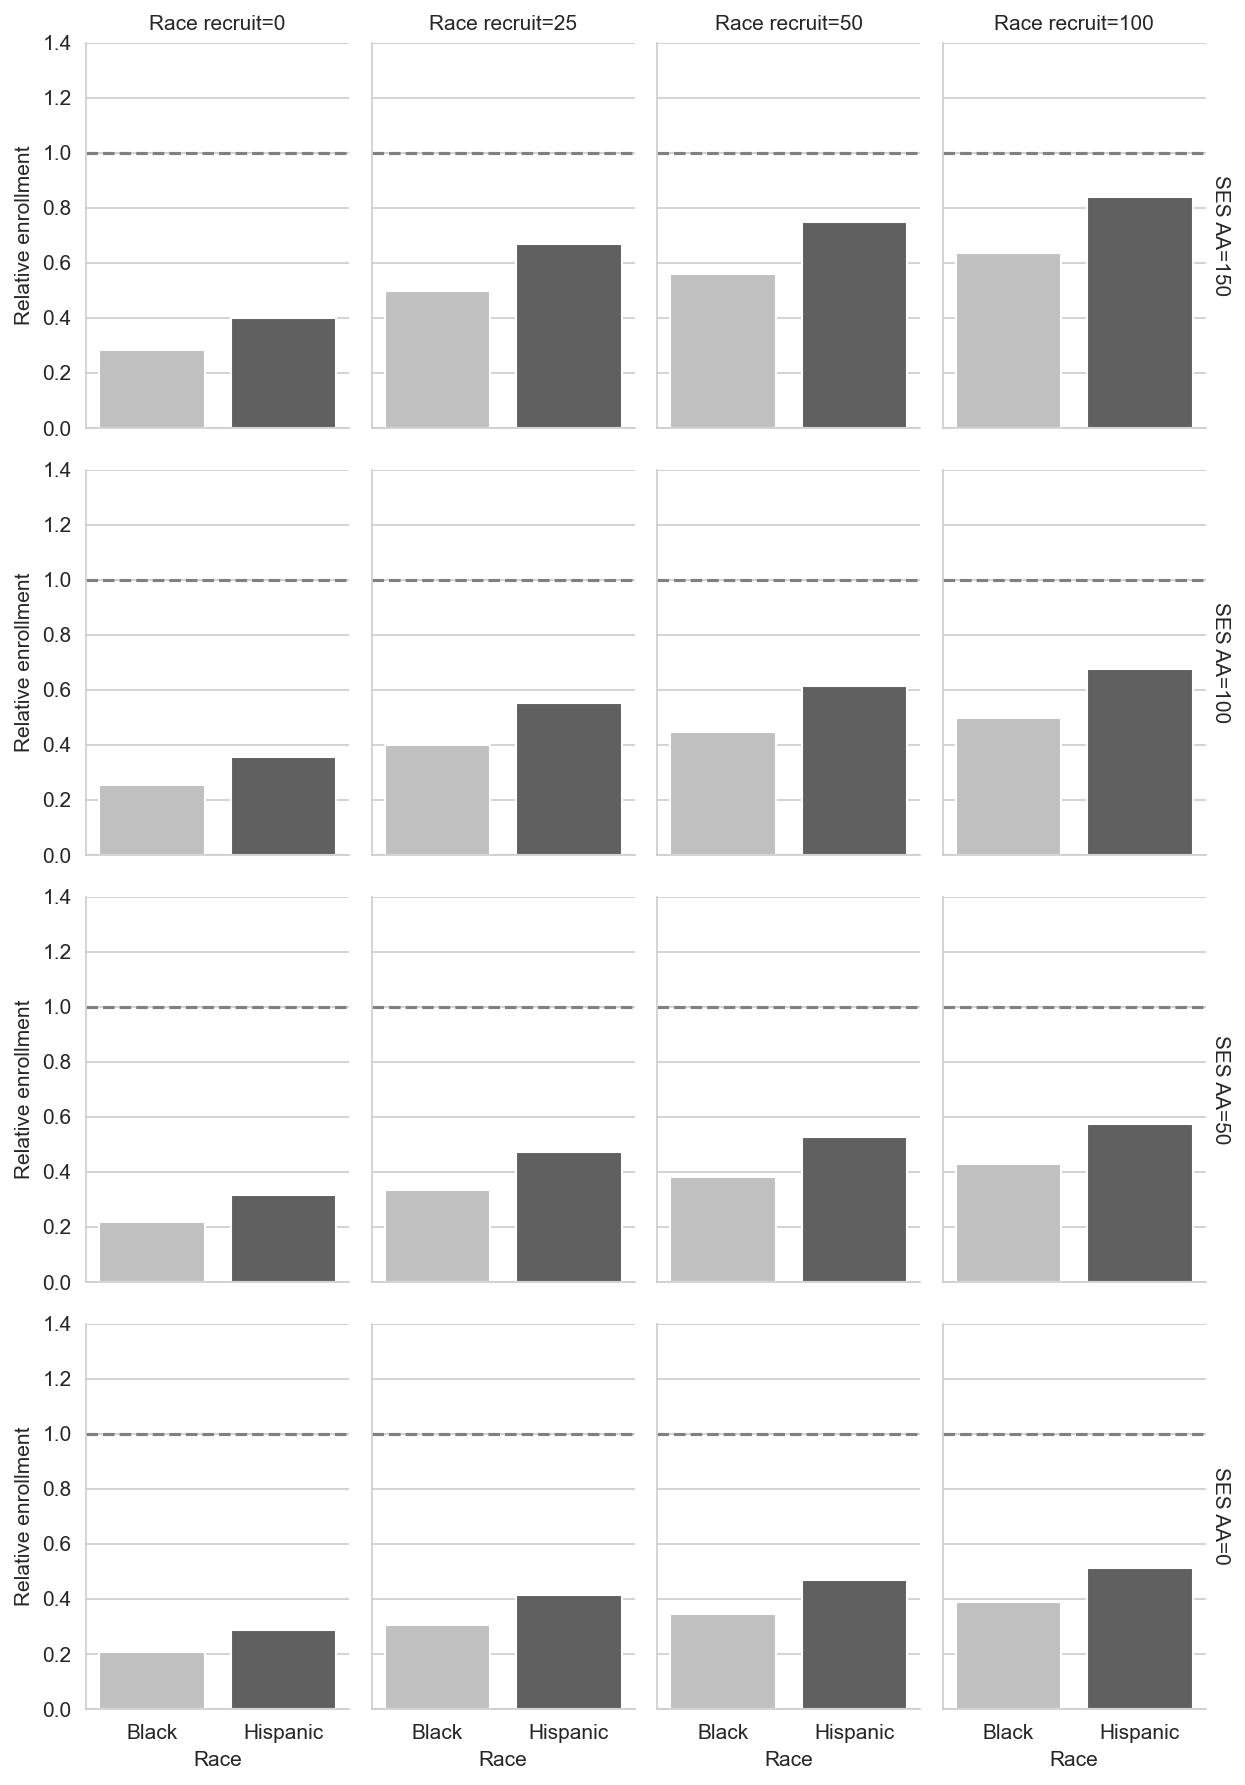

In [7]:
param_grid = {"wgt_aa_ses": [0, 50, 100, 150], "wgt_recruit": [0, 25, 50, 100]}
real_world = run_repeat_agg(pct_race_enroll, wgt_aa_race=260)
df_fig2 = (grid_run(param_grid, pct_race_enroll) / real_world).reset_index()

fig_2 = sns.FacetGrid(
    col="wgt_recruit",
    row="wgt_aa_ses",
    row_order=[150, 100, 50, 0],
    margin_titles=True,
    aspect=.7,
    data=df_fig2
)
fig_2.map(sns.barplot, "race", "pct_enroll", order=["Black", "Hispanic"], palette=bw2)
fig_2.refline(y=1)
fig_2.set(ylim=(0, 1.4))
fig_2.set_axis_labels("Race", "Relative enrollment")
fig_2.set_titles(col_template="Race recruit={col_name}", row_template="SES AA={row_name}")
fig_2.tight_layout()
fig_2.savefig("figures/fig2.png", bbox_inches="tight")

### Figure 8

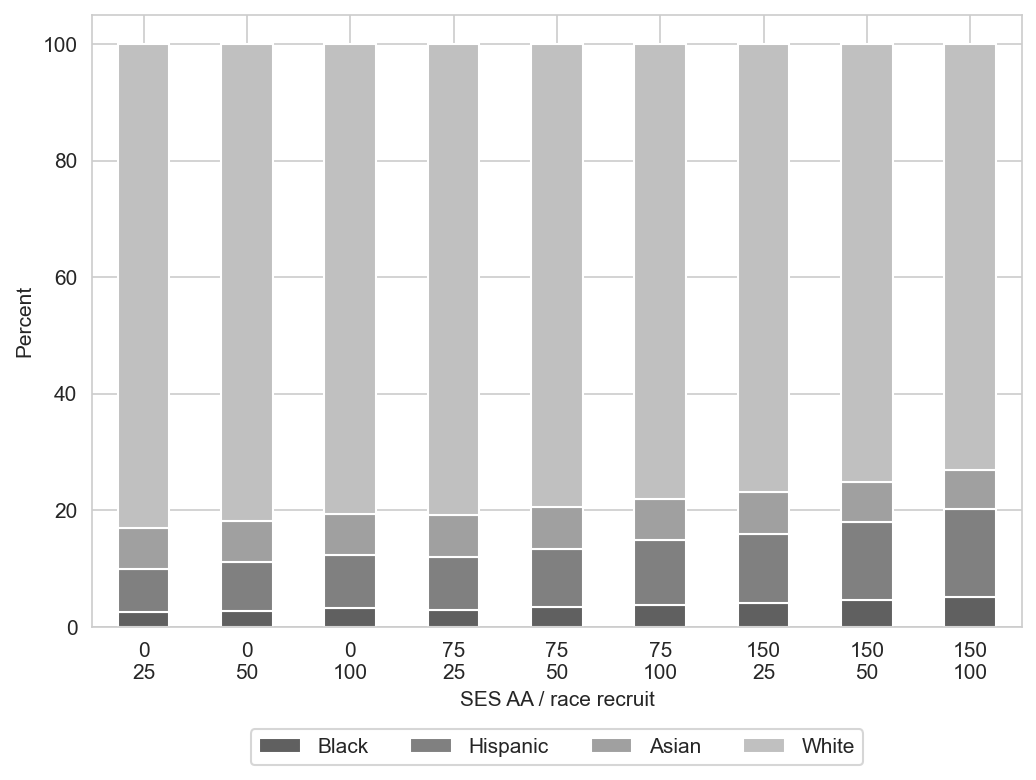

In [8]:
param_grid = {"wgt_aa_ses": [0, 75, 150], "wgt_recruit": [25, 50, 100]}
df_fig_a2 = (
    grid_run(param_grid, pct_race_enroll)
    .reset_index()
    .pivot_table(index=param_grid.keys(), columns="race", values="pct_enroll")[
        order_race
    ]
)

fig_a2, ax = plt.subplots()
df_fig_a2.plot.bar(
    stacked=True,
    colormap=cmap,
    rot=0,
    figsize=(8, 5.3),
    xlabel="SES AA / race recruit",
    ylabel="Percent",
    ax=ax
)
ax.set_xticklabels(df_fig_a2.index.map("{0[0]}\n{0[1]}".format).tolist())
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
fig_a2.savefig("figures/figA2.png", bbox_inches="tight")

### Figure 9

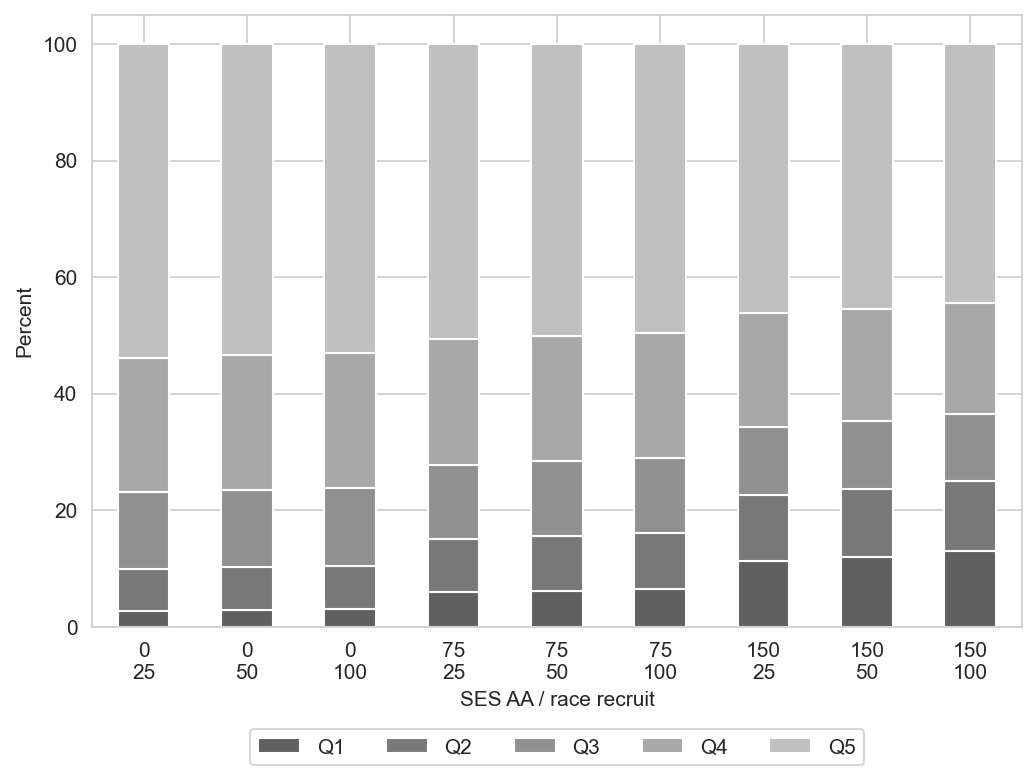

In [9]:
param_grid = {"wgt_aa_ses": [0, 75, 150], "wgt_recruit": [25, 50, 100]}
df_fig_a3 = (
    grid_run(param_grid, pct_ses_enroll)
    .reset_index()
    .pivot_table(index=param_grid.keys(), columns="res", values="pct_enroll")[
        order_res
    ]
)

fig_a3, ax = plt.subplots()
df_fig_a3.plot.bar(
    stacked=True,
    colormap=cmap,
    rot=0,
    figsize=(8, 5.3),
    xlabel="SES AA / race recruit",
    ylabel="Percent",
    ax=ax
)
ax.set_xticklabels(df_fig_a3.index.map("{0[0]}\n{0[1]}".format).tolist())
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=5)
fig_a3.savefig("figures/figA3.png", bbox_inches="tight")

### Figure 10

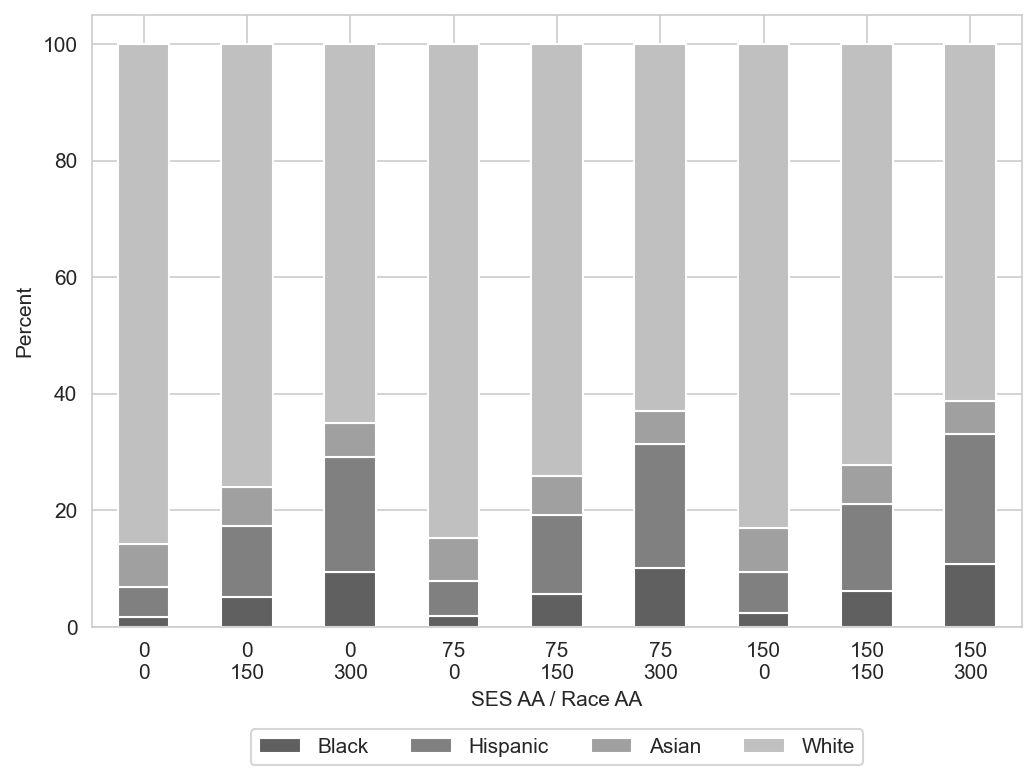

In [10]:
param_grid = {"wgt_aa_ses": [0, 75, 150], "wgt_aa_race": [0, 150, 300]}
df_fig_a4 = (
    grid_run(param_grid, pct_race_enroll)
    .reset_index()
    .pivot_table(index=param_grid.keys(), columns="race", values="pct_enroll")[
        order_race
    ]
)

fig_a4, ax = plt.subplots()
df_fig_a4.plot.bar(
    stacked=True,
    colormap=cmap,
    rot=0,
    figsize=(8, 5.3),
    xlabel="SES AA / Race AA",
    ylabel="Percent",
    ax=ax
)
ax.set_xticklabels(df_fig_a4.index.map("{0[0]}\n{0[1]}".format).tolist())
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
fig_a4.savefig("figures/figA4.png", bbox_inches="tight")

### Figure 11

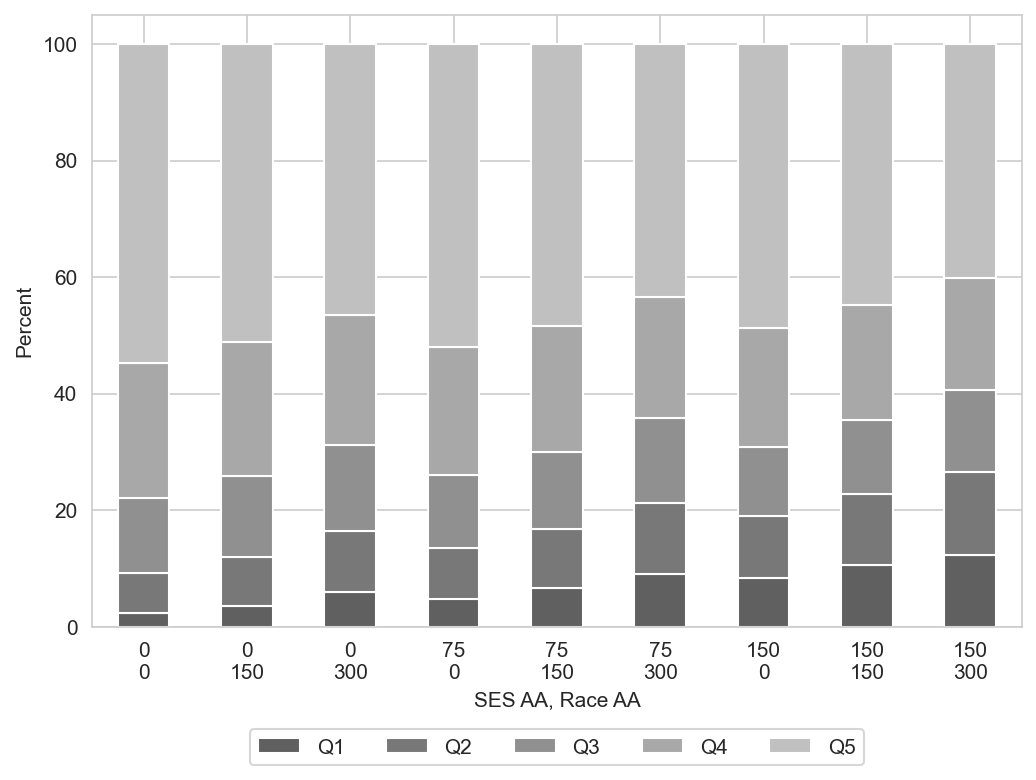

In [11]:
param_grid = {"wgt_aa_ses": [0, 75, 150], "wgt_aa_race": [0, 150, 300]}
df_fig_a5 =  (
    grid_run(param_grid, pct_ses_enroll)
    .reset_index()
    .pivot_table(index=param_grid.keys(), columns="res", values="pct_enroll")[
        order_res
    ]
)

fig_a5, ax = plt.subplots()
df_fig_a5.plot.bar(
    stacked=True,
    colormap=cmap,
    rot=0,
    figsize=(8, 5.3),
    xlabel="SES AA, Race AA",
    ylabel="Percent",
    ax=ax
)
ax.set_xticklabels(df_fig_a5.index.map("{0[0]}\n{0[1]}".format).tolist())
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=5)
fig_a5.savefig("figures/figA5.png", bbox_inches="tight")

# Appendix A

### Figure A.12

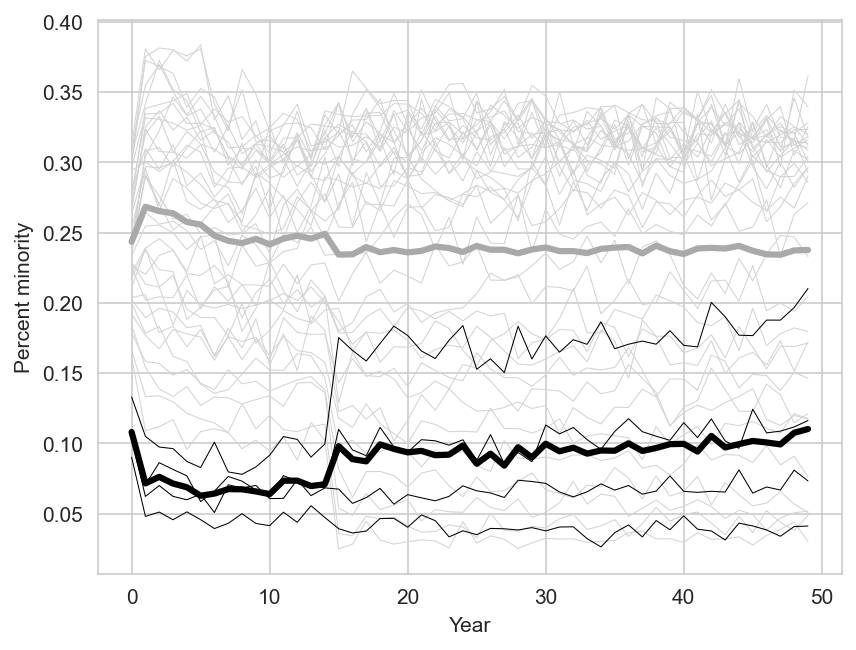

In [12]:
fig_c4_f1 = changes_bh_enrollment(ses_alt=True, n_years=50, wgt_aa_ses=150, wgt_recruit=100)
fig_c4_f1.savefig("figures/figC4_f1.png", bbox_inches="tight")

### Figure A.13

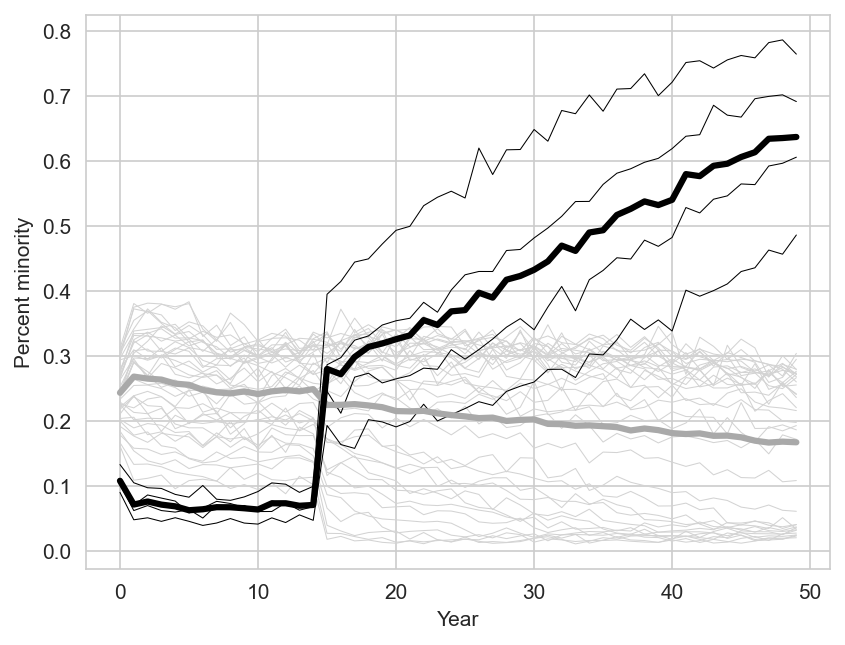

In [13]:
fig_c4_pen = changes_bh_enrollment(ses_penalty=True, n_years=50, wgt_aa_ses=150, wgt_recruit=100)
fig_c4_pen.savefig("figures/figC4_pen.png", bbox_inches="tight")

### Figure A.14

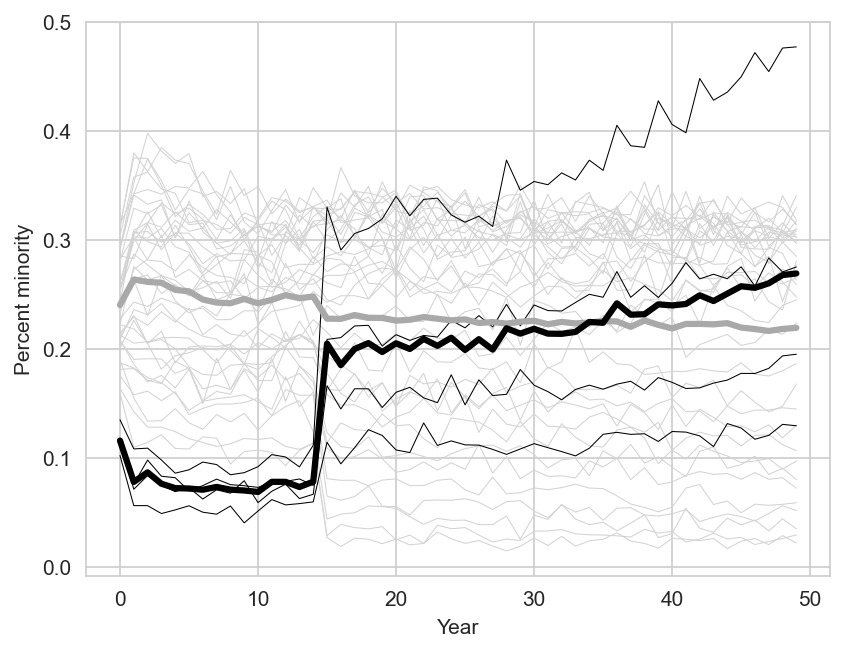

In [14]:
fig_c4_pq07 = changes_bh_enrollment(obs_qual_alt=True, n_years=50, wgt_aa_ses=150, wgt_recruit=100)
fig_c4_pq07.savefig("figures/figC4_pq07.png", bbox_inches="tight")

# Appendix B

## Figure B.15

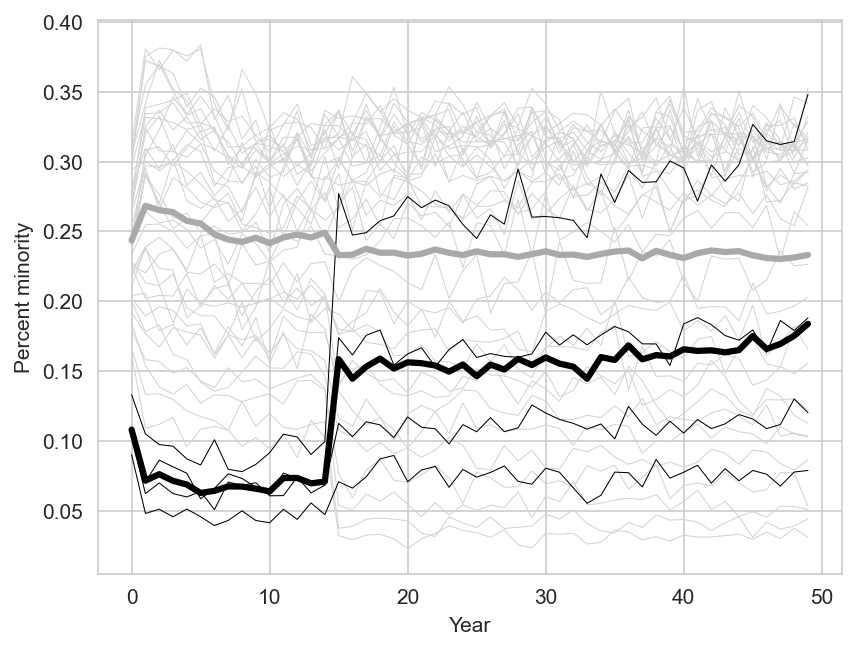

In [15]:
fig_c3 = changes_bh_enrollment(n_years=50, wgt_aa_ses=100, wgt_recruit=75)
fig_c3.savefig("figures/figC3.png", bbox_inches="tight")

## Figure B.16

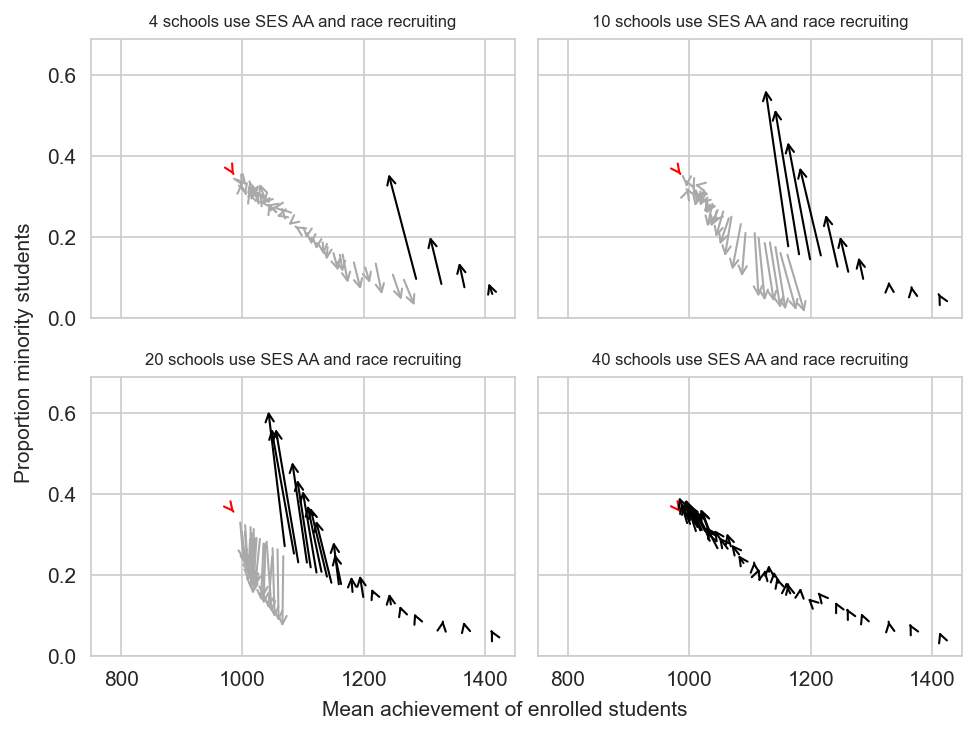

In [16]:
scenario_d2_d3 = {
    f"{n_active} schools use SES AA and race recruiting":
    run_repeat_agg(coll_shift_aux, wgt_aa_ses=150, wgt_recruit=100, n_active=n_active)
    for n_active in [4, 10, 20, 40]
}

fig_d2 = plot_d123(scenario_d2_d3, "race")
fig_d2.supxlabel('Mean achievement of enrolled students', y=-.01, fontsize="medium")
fig_d2.supylabel('Proportion minority students', x=-.01, fontsize="medium")
fig_d2.savefig("figures/figD2.png", bbox_inches="tight")

## Figure B.17

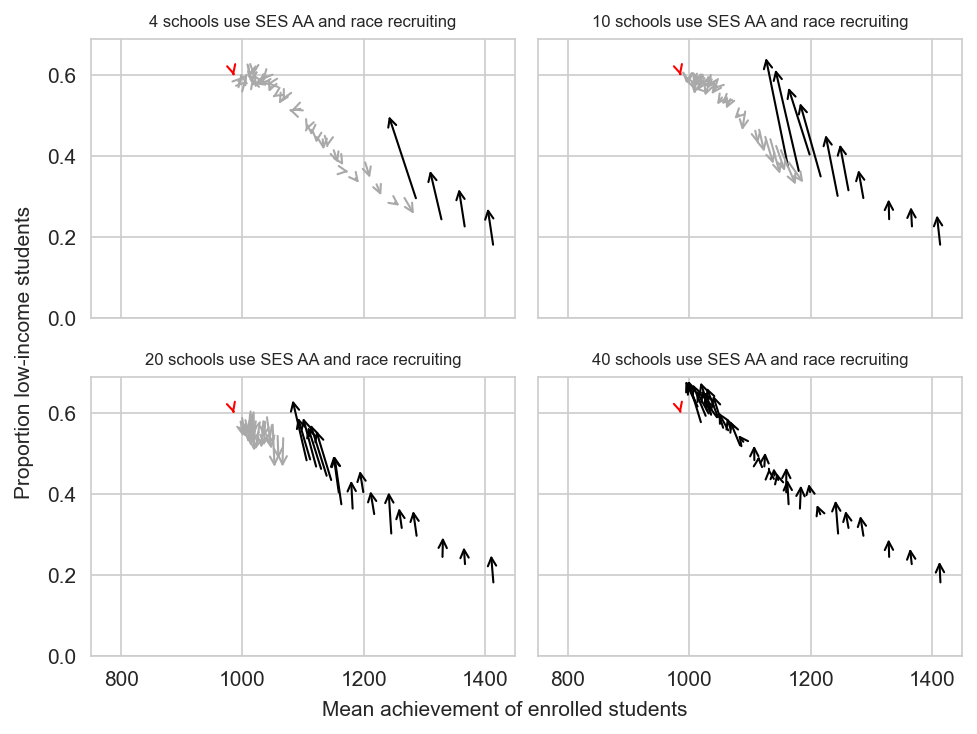

In [17]:
fig_d3 = plot_d123(scenario_d2_d3, "res")
fig_d3.supxlabel('Mean achievement of enrolled students', y=-.01, fontsize="medium")
fig_d3.supylabel('Proportion low-income students', x=-.01, fontsize="medium")
fig_d3.savefig("figures/figD3.png", bbox_inches="tight")

# Appendix C

## Table C.4

In [20]:
from itertools import starmap
from utils_figs import res_bins, run_repeat
import pandas as pd


def coll_shift_aux_wo_enroll(_, students, outcomes):
    idx_any = outcomes[outcomes.index.get_level_values("year").isin([14, 29]) & ~outcomes.enrollment]
    idx_app = outcomes[outcomes.index.get_level_values("year").isin([14, 29]) & ~outcomes.enrollment & outcomes.application]
    idx_adm = outcomes[outcomes.index.get_level_values("year").isin([14, 29]) & ~outcomes.enrollment & outcomes.admission]

    wo_enroll_any = students.loc[idx_any.droplevel("coll").index].assign(sel="any")
    wo_enroll_app = students.loc[idx_app.droplevel("coll").index].assign(sel="app")
    wo_enroll_adm = students.loc[idx_adm.droplevel("coll").index].assign(sel="adm")

    return (
        pd.concat([wo_enroll_any, wo_enroll_app, wo_enroll_adm])
        .groupby(["year", "sel"])
        .agg(
            {
                "ach": "mean",
                "race": lambda s: s.isin(["Black", "Hispanic"]).mean(),
                "res": lambda s: s.le(res_bins[2 + 1]).mean(),  # bottom two quintiles
            }
        )
        .reset_index()
    )

df = pd.concat(starmap(coll_shift_aux_wo_enroll, run_repeat(wgt_aa_ses=150, wgt_recruit=100)))

df[df.year == 14].groupby(["sel"]).mean().round(2)

,year,ach,race,res
sel,,,,
adm,14.0,1177.59,0.17,0.40
any,14.0,990.01,0.35,0.60
app,14.0,979.33,0.36,0.59
